In [2]:
import torch
import math
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms

# Holographic Light Transport Assignment

## Instructions

### 1. Download the Sample Hologram
Download the sample hologram image from the following link:
[Sample Hologram](https://github.com/kaanaksit/odak/blob/master/test/data/sample_hologram.png)

### 2. Image Parameters
- **Resolution**: (2400, 4094)
- **Wavelengths**: [639e-9, 515e-9, 473e-9] (in meters)
- **Pixel Pitch**: 3.74e-6 (in meters)
- **Distances**: [2.5e-3, 0, 2.5e-3] (in meters)

### 3. Phase-only Hologram
- **Amplitude**: 1
- **Phase**: `sample_hologram`

### 4. Create a Complex Field
Create a complex field where:
- **Amplitude**: 1
- **Phase**: provided by the `sample_hologram`

### 5. Phase Normalization
Normalize the phase of the complex field:
- **Range**: 0 - 255 (image pixel values)
- **Convert to radians**: `phase = sample_hologram / 255 * 2 * pi`

### 6. Define the Source Plane
```python
source_plane = complex_field(amplitude, phase)


In [3]:
def amplitude_tensor(image_path):
    image_shape = Image.open(image_path).size
    # generate 2-D amplitude tensor same size as the phase tensor all values are 1.0
    amplitude_tensor = torch.ones(image_shape)
    return amplitude_tensor.T
amplitudeTensor = amplitude_tensor("sample_hologram.png")
print(amplitudeTensor)
amplitudeTensor.shape

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])


torch.Size([2400, 4094])

In [4]:
def phase_image2phase_tensor(image_path):
    image_grey = Image.open(image_path).convert("L") # convert the image to gray scale
    transform = transforms.ToTensor()
    image_tensor = transform(image_grey)
    image_tensor = image_tensor.squeeze(0) # delete a dimension from the tensor
    image_tensor_normalized = image_tensor * 2 * math.pi
    return image_tensor_normalized # return the tensor between 0 and 2*pi
    
phaseTensor = phase_image2phase_tensor("sample_hologram.png")
print(phaseTensor)
print(phaseTensor.max())
phaseTensor.shape

tensor([[5.2237, 0.8624, 5.1497,  ..., 0.7885, 5.3469, 0.6653],
        [1.0349, 4.9280, 1.1581,  ..., 5.1251, 1.1334, 5.2729],
        [5.1497, 1.0842, 5.1251,  ..., 0.9610, 5.2729, 0.8870],
        ...,
        [1.3059, 4.9526, 1.3552,  ..., 4.9033, 1.3552, 5.0019],
        [4.9773, 1.3552, 4.9280,  ..., 1.4045, 4.9033, 1.3059],
        [1.2074, 5.0019, 1.3552,  ..., 4.9280, 1.3306, 5.0512]])
tensor(6.2585)


torch.Size([2400, 4094])

In [5]:
def source_plain(amplitude_tensor, phase_tensor):
    # generate a plain wave source
    source = amplitude_tensor * torch.exp(1j * phase_tensor)
    return source

In [6]:
def band_limited_angular_spectrum(
    amplitude=amplitudeTensor,
    phase=phaseTensor,
    z=0.0,
    wave_length=0.0,
    pixel_pitch=3.74e-6,
    band_limit = True,
    debug=True,
):
    if not isinstance(amplitude, torch.Tensor) or not isinstance(phase, torch.Tensor):
        raise ValueError("Amplitude tensor or phase tensor is required")
    if amplitude.shape != phase.shape:
        raise ValueError("Amplitude and phase tensors must have the same shape")

    dx = pixel_pitch  # the sampling interval
    sample_u = amplitude.shape[0]
    sample_v = amplitude.shape[1]
    S_x = sample_u * dx  # the x-size of the hologram plain
    S_y = sample_v * dx  # the y-size of the hologram plain

    # generate the 2-D frequency mesh
    freq_x = torch.fft.fftfreq(sample_u, dx)
    freq_y = torch.fft.fftfreq(sample_v, dx)
    if debug:
        print(
            "The highest positive frequency is u = {} and v = {}.".format(
                freq_x.max(), freq_y.max()
            )
        )
        print(
            "The highest negative frequency is u = {} and v = {}.".format(
                freq_x.min(), freq_y.min()
            )
        )
        print(
            "The resolution of the frequency is u = {} and v = {}.".format(
                freq_x[1] - freq_x[0], freq_y[1] - freq_y[0]
            )
        )

    freq_x_unsqueezed = torch.unsqueeze(freq_x, dim=1).expand(
        -1, len(freq_y)
    )  # expand to len(y) columns
    freq_y_unsqueezed = torch.unsqueeze(freq_y, dim=0).expand(
        len(freq_x), -1
    )  # expand to len(x) rows

    freq_square = freq_x_unsqueezed**2 + freq_y_unsqueezed**2

    freq_squre_max = torch.full((sample_u, sample_v), 1 / wave_length) ** 2
    w_square_0 = freq_squre_max - freq_square
    mask = w_square_0 > 0
    w_square = torch.where(mask, w_square_0, 0)

    # transfer function
    H_FR = torch.empty((sample_u, sample_v), dtype=torch.complex64)
    H_FR = torch.exp(2j * math.pi * z * torch.sqrt(w_square))

    if band_limit:
        # clipper the frequency
        d_u = 1 / S_x  # S_x instead of 2 * S_x
        d_v = 1 / S_y  # S_y instead of 2 * S_y
        u_limit = 1 / (math.sqrt((2 * d_u * z) ** 2 + 1) * wave_length)
        v_limit = 1 / (math.sqrt((2 * d_v * z) ** 2 + 1) * wave_length)
        mask_u = torch.abs(freq_x) < u_limit
        mask_v = torch.abs(freq_y) < v_limit
        mask = mask_u.unsqueeze(1) & mask_v.unsqueeze(0)
        H_FR = H_FR * mask

    sourcePlain = source_plain(amplitude, phase)
    sourcePlain_fourier = torch.fft.fft2(sourcePlain)
    G_0 = sourcePlain_fourier

    G_z = G_0 * H_FR

    # wrong!!!!!!
    # phase_z = torch.fft.ifftshift(torch.angle(G_z))
    # amplitude_z = torch.fft.ifftshift(torch.abs(G_z))

    # corrected
    phase_z = torch.angle(torch.fft.ifft2(G_z))
    amplitude_z = torch.abs(torch.fft.ifft2(G_z))

    g_z = torch.fft.ifft2(G_z)

    if debug:
        if mask.sum() == 2400 * 4094:
            print(
                "The maximum frequency is clipped to u = {} and v = {}.".format(
                    u_limit, v_limit
                )
            )
            print("The clipper is NOT working............")
        else:
            print(
                "The maximum frequency is clipped to u = {} and v = {}.".format(
                    u_limit, v_limit
                )
            )
            print("The clipper is working............")
            
    return g_z, amplitude_z, phase_z

In [7]:
g_z_red, amplitude_z_red, phase_z_red = band_limited_angular_spectrum(amplitudeTensor, phaseTensor, z=2.5e-3, wave_length=639e-9, pixel_pitch=3.74e-9)


The highest positive frequency is u = 133578432.0 and v = 133624528.0.
The highest negative frequency is u = -133689840.0 and v = -133689840.0.
The resolution of the frequency is u = 111408.203125 and v = 65310.1328125.
The maximum frequency is clipped to u = 2809.385144401939 and v = 4792.328077144729.
The clipper is working............


In [8]:
g_z_green_1, amplitude_z_green_1, phase_z_green_1 = band_limited_angular_spectrum(amplitudeTensor, phaseTensor, z=-2.5e-3, wave_length=515e-9, pixel_pitch=3.74e-6)
g_z_green_2, amplitude_z_green_2, phase_z_green_2 = band_limited_angular_spectrum(amplitudeTensor, phaseTensor, z=0.0, wave_length=515e-9, pixel_pitch=3.74e-6)
g_z_green_3, amplitude_z_green_3, phase_z_green_3 = band_limited_angular_spectrum(amplitudeTensor, phaseTensor, z=2.5e-3, wave_length=515e-9, pixel_pitch=3.74e-6)

The highest positive frequency is u = 133578.4375 and v = 133624.53125.
The highest negative frequency is u = -133689.84375 and v = -133689.84375.
The resolution of the frequency is u = 111.408203125 and v = 65.31013488769531.
The maximum frequency is clipped to u = 1696321.9552921436 and v = 1845824.9194371528.
The clipper is NOT working............
The highest positive frequency is u = 133578.4375 and v = 133624.53125.
The highest negative frequency is u = -133689.84375 and v = -133689.84375.
The resolution of the frequency is u = 111.408203125 and v = 65.31013488769531.
The maximum frequency is clipped to u = 1941747.5728155337 and v = 1941747.5728155337.
The clipper is NOT working............
The highest positive frequency is u = 133578.4375 and v = 133624.53125.
The highest negative frequency is u = -133689.84375 and v = -133689.84375.
The resolution of the frequency is u = 111.408203125 and v = 65.31013488769531.
The maximum frequency is clipped to u = 1696321.9552921436 and v = 

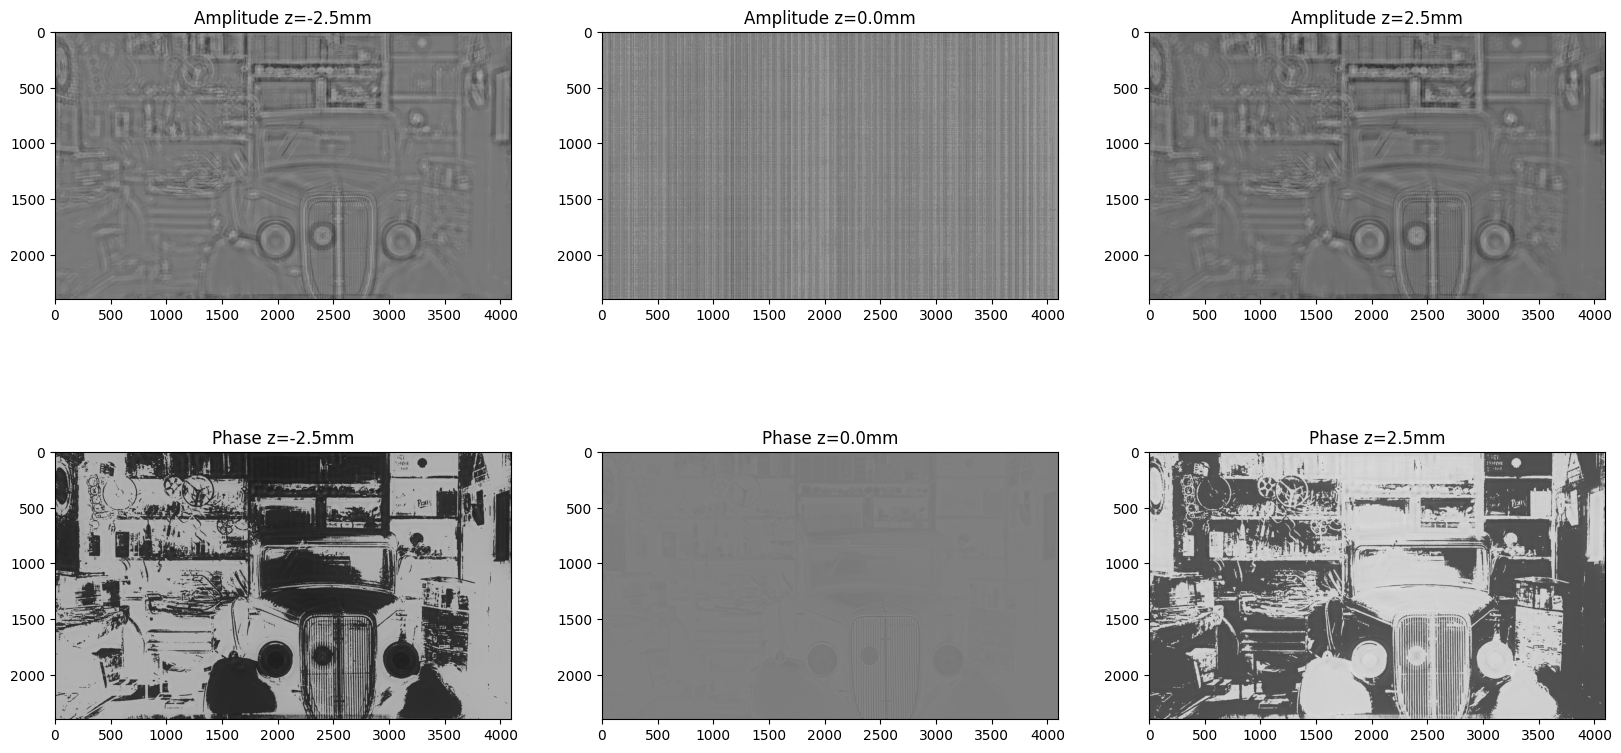

In [9]:
# plot the amplitude and phase of the reconstructed image
plt.figure(figsize=(20, 10))
plt.subplot(231)
plt.imshow(amplitude_z_green_1, cmap="gray")
plt.title("Amplitude z=-2.5mm")
plt.subplot(232)
plt.imshow(amplitude_z_green_2, cmap="gray")
plt.title("Amplitude z=0.0mm")
plt.subplot(233)
plt.imshow(amplitude_z_green_3, cmap="gray")
plt.title("Amplitude z=2.5mm")
plt.subplot(234)
plt.imshow(phase_z_green_1, cmap="gray")
plt.title("Phase z=-2.5mm")
plt.subplot(235)
plt.imshow(phase_z_green_2, cmap="gray")
plt.title("Phase z=0.0mm")
plt.subplot(236)
plt.imshow(phase_z_green_3, cmap="gray")
plt.title("Phase z=2.5mm")
plt.show()

The highest positive frequency is u = 133578.4375 and v = 133624.53125.
The highest negative frequency is u = -133689.84375 and v = -133689.84375.
The resolution of the frequency is u = 111.408203125 and v = 65.31013488769531.
The maximum frequency is clipped to u = 1367145.2378332615 and v = 1487636.6721598336.
The clipper is NOT working............
The highest positive frequency is u = 133578.4375 and v = 133624.53125.
The highest negative frequency is u = -133689.84375 and v = -133689.84375.
The resolution of the frequency is u = 111.408203125 and v = 65.31013488769531.
The maximum frequency is clipped to u = 1696321.9552921436 and v = 1845824.9194371528.
The clipper is NOT working............
The highest positive frequency is u = 133578.4375 and v = 133624.53125.
The highest negative frequency is u = -133689.84375 and v = -133689.84375.
The resolution of the frequency is u = 111.408203125 and v = 65.31013488769531.
The maximum frequency is clipped to u = 1941346.2377232313 and v = 

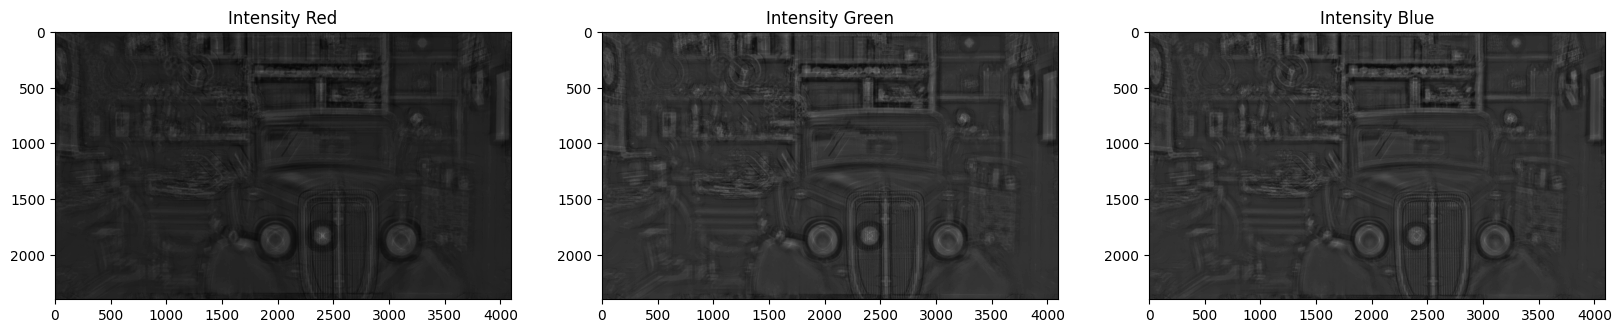

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


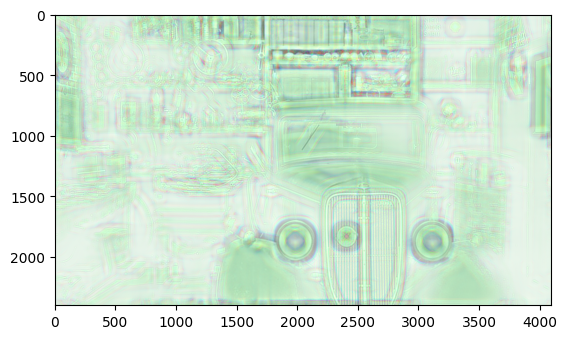

In [11]:
# using the same phase tensor and amplitude tensor to reconstruct the image with different wave length
g_z_red, amplitude_z_red, phase_z_red = band_limited_angular_spectrum(amplitudeTensor, phaseTensor, z=2.5e-3, wave_length=639e-9, pixel_pitch=3.74e-6)
g_z_green, amplitude_z_green, phase_z_green = band_limited_angular_spectrum(amplitudeTensor, phaseTensor, z=2.5e-3, wave_length=515e-9, pixel_pitch=3.74e-6)
g_z_blue, amplitude_z_blue, phase_z_blue = band_limited_angular_spectrum(amplitudeTensor, phaseTensor, z=2.5e-3, wave_length=450e-9, pixel_pitch=3.74e-6)

# plot the intensity of the reconstructed image
plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.imshow(torch.abs(g_z_red)**2, cmap="gray")
plt.title("Intensity Red")
plt.subplot(132)
plt.imshow(torch.abs(g_z_green)**2, cmap="gray")
plt.title("Intensity Green")
plt.subplot(133)
plt.imshow(torch.abs(g_z_blue)**2, cmap="gray")
plt.title("Intensity Blue")
plt.show()


In [59]:
import cProfile

cProfile.run(
    "band_limited_angular_spectrum(amplitudeTensor, phaseTensor, z=2.5e-3, wave_length=639e-9, pixel_pitch=3.74e-6,band_limit = True, debug = False)"
)  # profile the function

         54 function calls in 1.235 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.111    0.111    0.219    0.219 2537823064.py:1(source_plain)
        1    0.266    0.266    1.235    1.235 3527326175.py:1(band_limited_angular_spectrum)
        1    0.000    0.000    1.235    1.235 <string>:1(<module>)
        3    0.000    0.000    0.014    0.005 _tensor.py:34(wrapped)
        2    0.000    0.000    0.000    0.000 _tensor.py:964(__len__)
        1    0.000    0.000    1.235    1.235 {built-in method builtins.exec}
        2    0.000    0.000    0.000    0.000 {built-in method builtins.isinstance}
        2    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        2    0.000    0.000    0.000    0.000 {built-in method math.sqrt}
        1    0.042    0.042    0.042    0.042 {built-in method torch._C._fft.fft_fft2}
        2    0.001    0.000    0.001    0.000 {built-in method torch._C._fft.f